In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import numpy as np
import random 

import gym
from gym import spaces

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

#device to run model on 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

!pip3 install rlcard

import rlcard
from rlcard.agents import DQNAgent

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
class ActorNetwork(nn.Module):

    def __init__(self, state_size,action_size, lay1_size=128):
        super(ActorNetwork,self).__init__() 
        self.fc1= nn.Linear(state_size,lay1_size)
        self.fc2 = nn.Linear(lay1_size,action_size)
        
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim = 1)

In [3]:
class CriticNetwork(nn.Module):

    def __init__(self, state_size, lay1_size=128):
        super(CriticNetwork,self).__init__() 
        self.fc1= nn.Linear(state_size,lay1_size)
        self.fc2 = nn.Linear(lay1_size,1)
        
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [4]:
class AC_Agent:
    
    def __init__(self, state_size, action_size, gamma, lr, lay1_size=32):
        #initalize the agent. Since this is a general agent, I won't specify the environment inside the agent.
        #Instead, the informatino will synx from the environment. 
        #save the parameters
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        
        
        #initalize actor and critic network
        self.actor = ActorNetwork(state_size, action_size, lay1_size).to(DEVICE)
        self.critic = CriticNetwork(state_size, lay1_size).to(DEVICE)     

        #initalize optimizers for the networks
        self.actor_optimizer = optim.SGD(self.actor.parameters(),lr=lr)
        self.critic_optimizer = optim.SGD(self.critic.parameters(),lr=lr)
        
               
        #initalize step count
        self.step_count = 0
    
    def action(self, state):
      #input: the current state
      #output: the action selected by the actor network and the log probability of the action

      #get the action probability from the actor network
        action_probs = self.actor(torch.from_numpy(state).float().unsqueeze(0).to(DEVICE))
      #categorical the action probability to get the action & calculate the log probabilty
        c = Categorical(action_probs)
        action = c.sample()
        
        return action, c.log_prob(action)
    
                 
    
    def step(self, I, state, action, log, next_state, reward, done, discounted_reward):
        #get state value of current state from critic network
        
        v = self.critic(torch.from_numpy(state).float().unsqueeze(0).to(DEVICE))
       
        if done:
          #if done, the state value of next state is 0
            Vp = torch.tensor([0]).float().unsqueeze(0).to(DEVICE)
        else:
          #otherwise, get the state value for the next state
            Vp = self.critic(torch.from_numpy(next_state).float().unsqueeze(0).to(DEVICE))

        #calculate the critic loss of the model based on the TD error  

        #discounted_reward = reward + self.gamma * discounted_reward  
        discounted_reward = torch.tensor([discounted_reward]).float().unsqueeze(0).to(DEVICE)
        # in our case, advantage function Q-V, Q can be estimated as return which is discounted reward
        critic_loss = F.mse_loss(discounted_reward, v)
        
        actor_loss = -log * (discounted_reward - v.item())
        actor_loss *= I
        actor_loss = torch.tensor([actor_loss],requires_grad=True)
        
        #update the networks
        self.actor_optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        self.actor_optimizer.step()
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        #update I
        I = I * self.gamma
        
        return self, I
        
        


  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'episode vs. total reward')

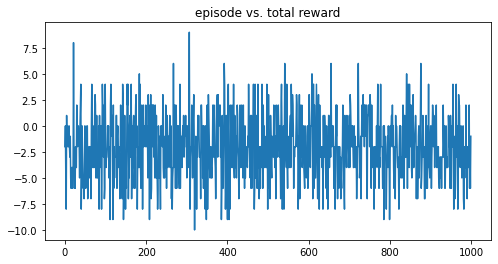

In [5]:
#Agent for env 1 & introduce environment
gamma = 0.99
agent_AC = AC_Agent(gamma=0.99, state_size = 2, action_size = 2, lr = 0.005)
env = rlcard.make("blackjack")

#initalize total rewards
total_rewards = [] 

#using tqdm to check the learning progress
for i in tqdm(range(10000)):
    #reset environment and parameters
    
    state, _ = env.reset()
    state = state["obs"]
    I = 1
    final_reward = 0
    discounted_reward = 0
    #maximum 10000 steps
    for t in range(20):
        #pick the action a
        action, log = agent_AC.action(state)

        #execute the action A and ovserve reward r and next state s'
        next_state,_ = env.step(action)
        next_state = next_state["obs"]
        reward = env.get_payoffs()[0]
        #update the agent
        if next_state[0] > 21 or action == 1:
            done = 1
        else:
            done = 0  
        discounted_reward = reward + gamma*discounted_reward
        agent_AC, I = agent_AC.step(I, state, action,log, next_state, reward, done, discounted_reward)

        #update state and total reward
        state = next_state
        final_reward += reward

        if done:
            break

    total_rewards.append(final_reward) ## sae the most recent score



tr = [] 

for i in range(1000):
    r = 0
    for x in range(10):
        r+=total_rewards[i*10+x]
    tr.append(r)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(1000), tr)
plt.title("episode vs. total reward")


In [8]:
#Do the 10 eplision based on greedy actions
#initalize total rewards
total_rewards = [] 
win_rate = 0
win_tie_rate = 0
#using tqdm to check the learning progress
for i in tqdm(range(100)):
    #reset environment and parameters
    state,_ = env.reset()
    state = state["obs"]
    I = 1
    final_reward = 0

    #maximum 10000 steps
    for t in range(20):
        #pick the action a

        action, log = agent_AC.action(state)

        #execute the action A and ovserve reward r and next state s'
        #next_state,reward,done,_ = env.step(action.item())
        next_state,_ = env.step(action)
        next_state = next_state["obs"]
        reward = env.get_payoffs()[0]
        if next_state[0] > 21 or action == 1:
            done = 1
        else:
            done = 0 
        
        discounted_reward = reward + gamma*discounted_reward
        agent_AC, I = agent_AC.step(I, state, action,log, next_state, reward, done, discounted_reward)
        #update the agent
        #agent_AC, I = agent_AC.step(I, state, action,log, next_state, reward, done)

        #update state and total reward
        state = next_state
        final_reward += reward

        if done:
            if reward == 1:     #if the last reward is +1, means agent wins the game
              win_rate += 1
              win_tie_rate += 1 
              
            if reward == 0:     # if the last reward is 0, means tie 
              win_tie_rate += 1
            break

    total_rewards.append(final_reward) ## sae the most recent score

 


  0%|          | 0/100 [00:00<?, ?it/s]

win rate:  0.4
win_tie_rate:  0.44


<Figure size 720x720 with 0 Axes>

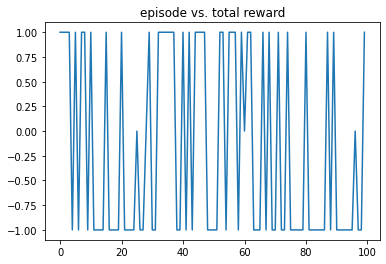

<Figure size 720x720 with 0 Axes>

In [9]:
print("win rate: ", win_rate/100)
print("win_tie_rate: ", win_tie_rate/100)
plt.plot(total_rewards)
plt.title("episode vs. total reward")
plt.figure(2,figsize = (10,10))


